In [27]:
import pandas as pd
import numpy as np
import plotnine as p9
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools

import warnings
warnings.simplefilter("ignore")

from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 6,6

from sklearn import neighbors, preprocessing, impute, metrics, model_selection, linear_model, svm, feature_selection

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


bank = pd.read_csv('../data/bank.csv',sep=';',na_values=['unknown',999,'nonexistent'])
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        4521 non-null   int64  
 1   job        4483 non-null   object 
 2   marital    4521 non-null   object 
 3   education  4334 non-null   object 
 4   default    4521 non-null   object 
 5   balance    4519 non-null   float64
 6   housing    4521 non-null   object 
 7   loan       4521 non-null   object 
 8   contact    3197 non-null   object 
 9   day        4521 non-null   int64  
 10  month      4521 non-null   object 
 11  duration   4521 non-null   int64  
 12  campaign   4521 non-null   int64  
 13  pdays      4521 non-null   int64  
 14  previous   4521 non-null   int64  
 15  poutcome   816 non-null    object 
 16  y          4521 non-null   object 
dtypes: float64(1), int64(6), object(10)
memory usage: 600.6+ KB


In [8]:
bank_tr, bank_te = model_selection.train_test_split(bank,test_size=.33)

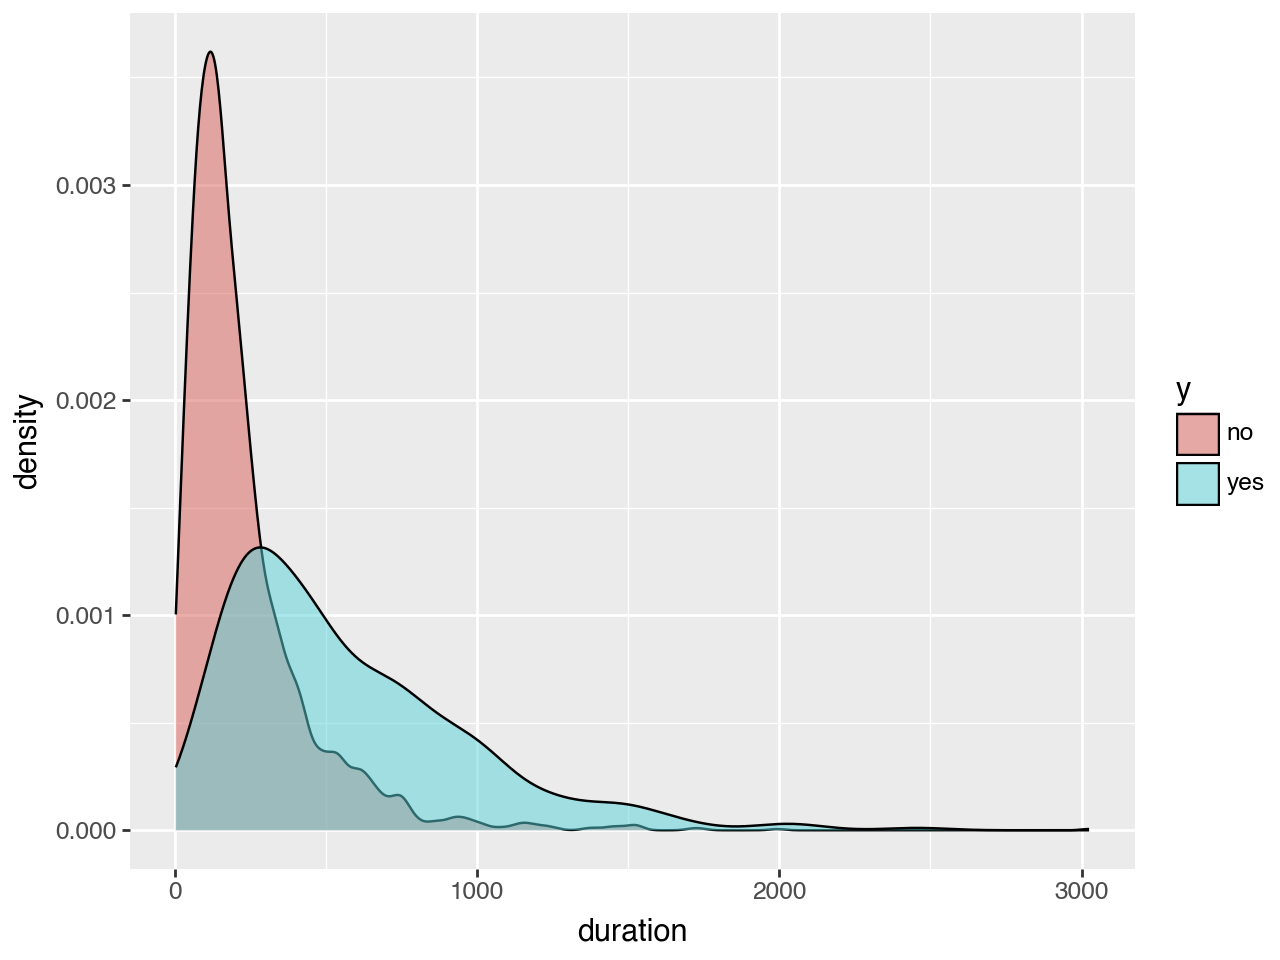

In [9]:
p9.ggplot(bank_tr[['duration','y']].dropna(axis=0)) + p9.aes(x = 'duration',fill = 'y')\
+ p9.geom_density(alpha=.5)

In [10]:
## IGNORE

def train_bank_to_xy(bank):
    """standardize and impute training"""
    bank_sel = bank[['age','balance','duration','y']].values
    X,y = bank_sel[:,:-1], bank_sel[:,-1]
    scaler = preprocessing.StandardScaler().fit(X)
    imputer = impute.SimpleImputer(fill_value=0).fit(X)
    trans_prep = lambda Z: imputer.transform(scaler.transform(Z)) 
    X = trans_prep(X)
    y = 2*(y == 'yes')-1
    return (X, y), trans_prep

def test_bank_to_xy(bank, trans_prep):
    """standardize and impute test"""
    bank_sel = bank[['age','balance','duration','y']].values
    X,y = bank_sel[:,:-1], bank_sel[:,-1]
    X = trans_prep(X)
    y = 2*(y == 'yes')-1
    return (X, y)

(X_tr, y_tr), trans_prep  = train_bank_to_xy(bank_tr)
X_te, y_te = test_bank_to_xy(bank_te, trans_prep)

## Set the score to be standardized duration
score_dur = X_te[:,2]

### Confusion matrix and metrics

<table style='font-family:"Courier New", Courier, monospace; font-size:120%'>
    <tr><td></td><td>Pred 1</td><td>Pred -1</td></tr>
    <tr><td>True 1</td><td>True Pos</td><td>False Neg</td></tr>
    <tr><td>True -1</td><td>False Pos</td><td>True Neg</td></tr>
</table>

$$
\textrm{FPR} = \frac{FP}{FP+TN}
$$
$$
\textrm{TPR, Recall} = \frac{TP}{TP + FN}
$$
$$
\textrm{Precision} = \frac{TP}{TP + FP}
$$

Confusion matrix, without normalization
[[  69  105]
 [  98 1220]]


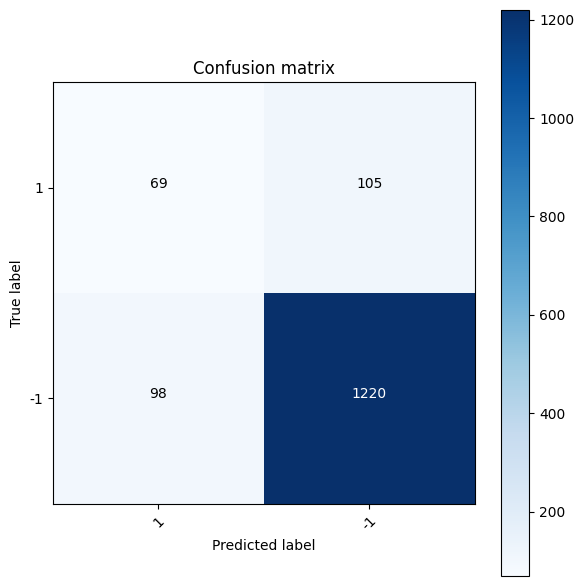

In [33]:
def plot_conf_score(y_te,score,tau):
    y_pred = 2*(score > tau) - 1
    classes = [1,-1]
    conf = metrics.confusion_matrix(y_te, y_pred,labels=classes)
    plot_confusion_matrix(conf, classes)

plot_conf_score(y_te,score_dur,1.)

Confusion matrix, without normalization
[[  31  143]
 [  28 1290]]


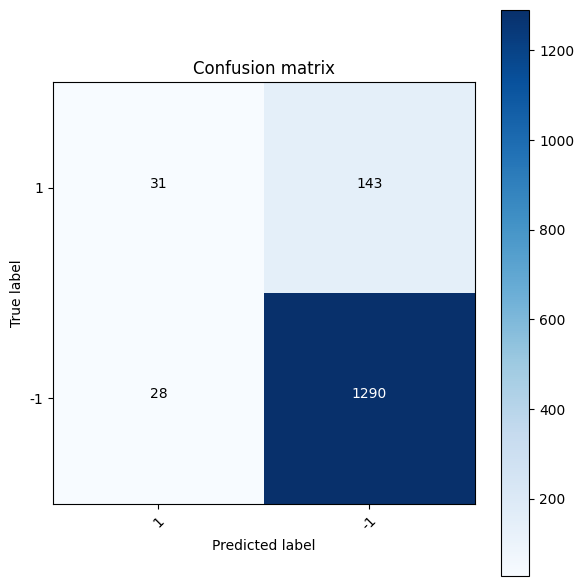

In [34]:
plot_conf_score(y_te,score_dur,2.)

In [35]:
glm = linear_model.LogisticRegression()
glm.fit(X_tr, y_tr)
score_glm = glm.predict_proba(X_te)[:,1]
fpr_dur, tpr_dur, threshs = metrics.roc_curve(y_te,score_dur)

In [45]:
def plot_temp():
    plt.figure(figsize=(6,6))
    plt.plot(fpr_dur,tpr_dur,label='duration')
    plt.plot(fpr_glm,tpr_glm,label='knn')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.title("ROC")
    plt.show()

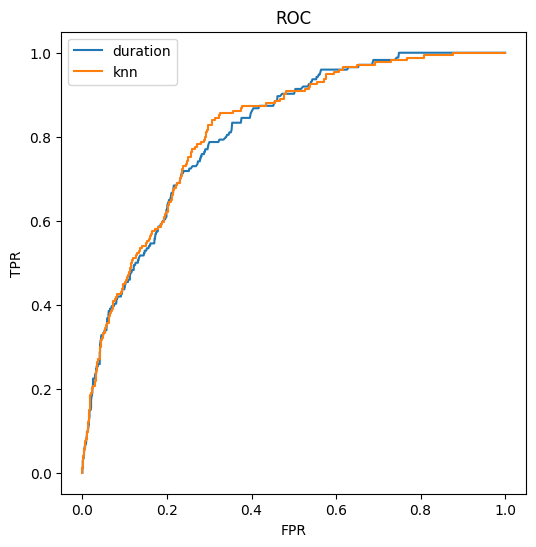

In [47]:
fpr_glm, tpr_glm, threshs = metrics.roc_curve(y_te,score_glm)
plot_temp()

In [42]:
def plot_temp():
    plt.figure(figsize=(6,6))
    plt.plot(rec_dur,prec_dur,label='duration')
    plt.plot(rec_glm,prec_glm,label='logistic')
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.legend()
    plt.title("PR curve")
    plt.show()

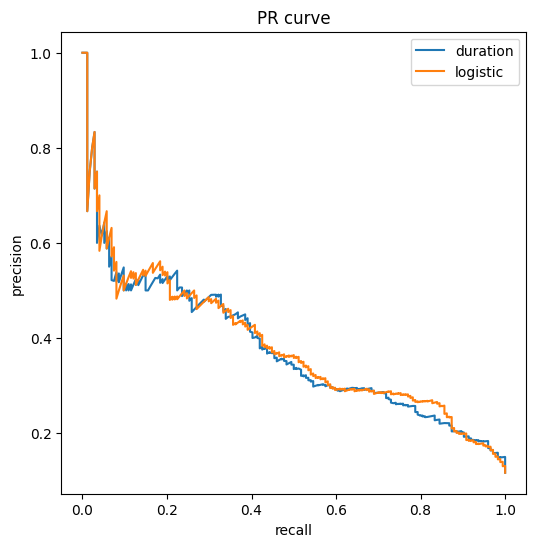

In [44]:
prec_dur, rec_dur, threshs = metrics.precision_recall_curve(y_te,score_dur)
prec_glm, rec_glm, threshs = metrics.precision_recall_curve(y_te,score_glm)
plot_temp()

In [51]:
(y_te > 0).mean()

0.11662198391420911

In [52]:
def lm_sim(N = 100):
    """simulate a binary response and two predictors"""
    X1 = (np.random.randn(N*2)).reshape((N,2)) + np.array([2,3])
    X0 = (np.random.randn(N*2)).reshape((N,2)) + np.array([.5,1.5])
    y = - np.ones(N*2)
    y[:N]=1
    X = np.vstack((X1,X0))
    return X, y, X0, X1

X_sim,y_sim,X0,X1 = lm_sim()

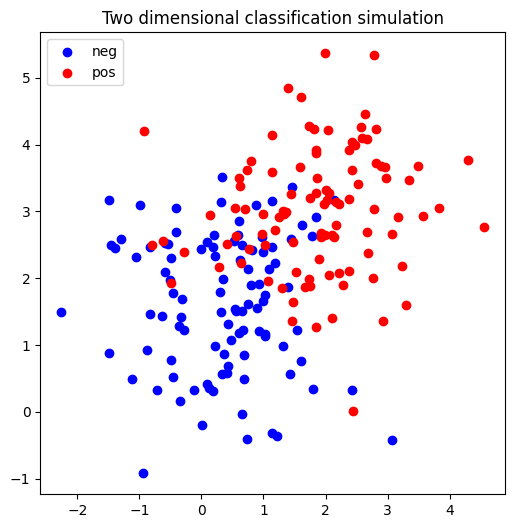

In [55]:
plt.scatter(X0[:,0],X0[:,1],c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],c='r',label='pos')
plt.title("Two dimensional classification simulation")
_ = plt.legend(loc=2)
plt.show()

In [56]:
lr_sim = linear_model.LogisticRegression()
lr_sim.fit(X_sim,y_sim)

beta1 = lr_sim.coef_[0,0]
beta2 = lr_sim.coef_[0,1]
beta0 = lr_sim.intercept_

mults=0.8
T = np.linspace(-1,4,100)
x2hat = -(beta0 + beta1*T) / beta2
line1 = -(beta0 + np.random.randn(1)*2 + 
          (beta1 + np.random.randn(1)*mults) *T) / (beta2 + np.random.randn(1)*mults)
line2 = -(beta0 + np.random.randn(1)*2 + 
          (beta1 + np.random.randn(1)*mults) *T) / (beta2 + np.random.randn(1)*mults)
line3 = -(beta0 + np.random.randn(1)*2 + 
          (beta1 + np.random.randn(1)*mults) *T) / (beta2 + np.random.randn(1)*mults)

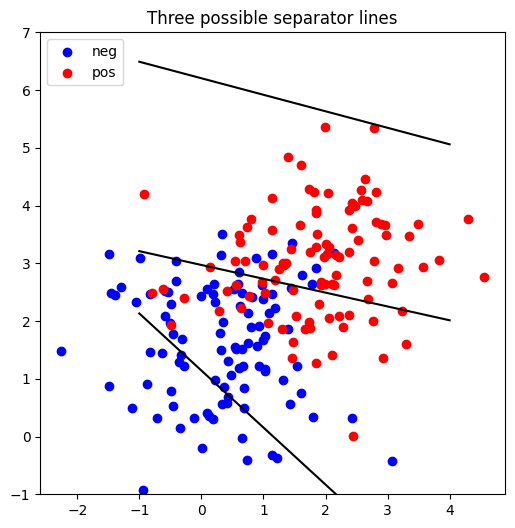

In [59]:
plt.scatter(X0[:,0],X0[:,1],c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],c='r',label='pos')
plt.plot(T,line3,c='k')
plt.plot(T,line1,c='k')
plt.plot(T,line2,c='k')
plt.ylim([-1,7])
plt.title("Three possible separator lines")
_ = plt.legend(loc=2)
plt.show()

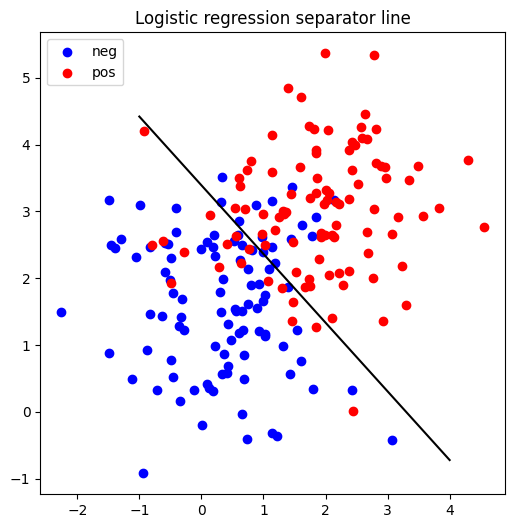

In [62]:
plt.scatter(X0[:,0],X0[:,1],c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],c='r',label='pos')
plt.plot(T,x2hat,c='k')
plt.title("Logistic regression separator line")
_ = plt.legend(loc=2)
plt.show()

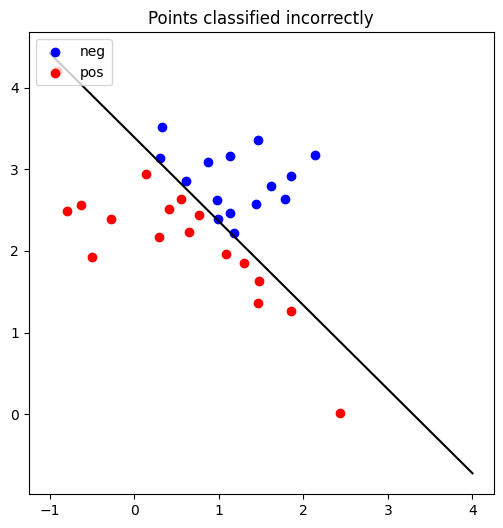

In [63]:
N = 100
y_hat = lr_sim.predict(X_sim)
plt.scatter(X0[y_hat[N:] == 1,0],X0[y_hat[N:] == 1,1],c='b',label='neg')
plt.scatter(X1[y_hat[:N] == -1,0],X1[y_hat[:N] == -1,1],c='r',label='pos')
plt.plot(T,x2hat,c='k')
plt.title("Points classified incorrectly")
_ = plt.legend(loc=2)
plt.show()

Logistic regression uses a loss function that mimics some of the behavior of the 0-1 loss, but is not discontinuous.  In this way, it is a surrogate loss, that acts as a surrogate for the 0-1 loss.  It turns out that it is one of a few nice options for surrogate losses.  Notice that we can rewrite the 0-1 loss for a linear classifier as
$$
\ell_{0/1}(\beta,x_i,y_i) = 1 \{ y_i \beta^\top x_i < 0 \}.
$$
Throughout we will denote our losses as functions of $\beta$ to reflect the fact that we are only considering linear classifiers.
The logistic loss and the hinge loss are also functions of $y_i \beta^\top x_i$, they are 
$$
\ell_{L} (\beta, x_i, y_i) = \log(1 + \exp(-y_i \beta^\top x_i))
\tag{logistic}
$$
and 
$$
\ell_{H} (\beta, x_i, y_i) = (1 - y_i \beta^\top x_i))_+
\tag{hinge}
$$
where $a_+ = a 1\{ a > 0\}$ is the positive part of the real number $a$.

If we are free to select training loss functions, then why not square error loss?  For example, we could choose
$$
\ell_{S} (\beta, x_i, y_i) = (y_i - \beta^\top x_i))^2 = (1 - y_i \beta^\top x_i))^2.
\tag{square error}
$$
In order to motivate the use of these, let's plot the losses as a function of $y_i \beta^\top x_i$.

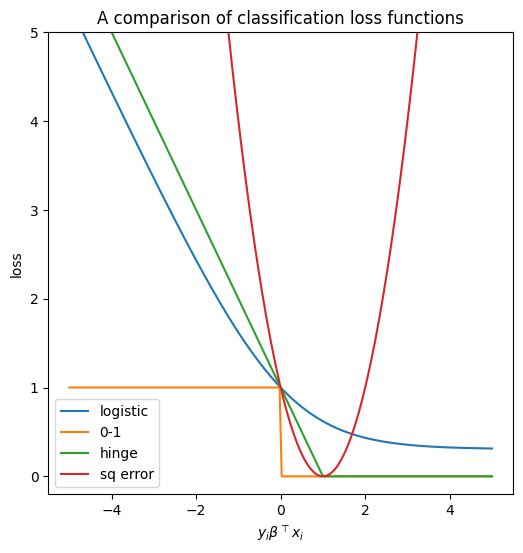

In [66]:
z_range = np.linspace(-5,5,200)
zoloss = z_range < 0
l2loss = (1-z_range)**2.
hingeloss = (1 - z_range) * (z_range < 1)
logisticloss = np.log(1 + np.exp(-z_range))
plt.plot(z_range, logisticloss + 1 - np.log(2.),label='logistic')
plt.plot(z_range, zoloss,label='0-1')
plt.plot(z_range, hingeloss,label='hinge')
plt.plot(z_range, l2loss,label='sq error')
plt.ylim([-.2,5])
plt.xlabel(r'$y_i \beta^\top x_i$')
plt.ylabel('loss')
plt.title('A comparison of classification loss functions')
_ = plt.legend()
plt.show()

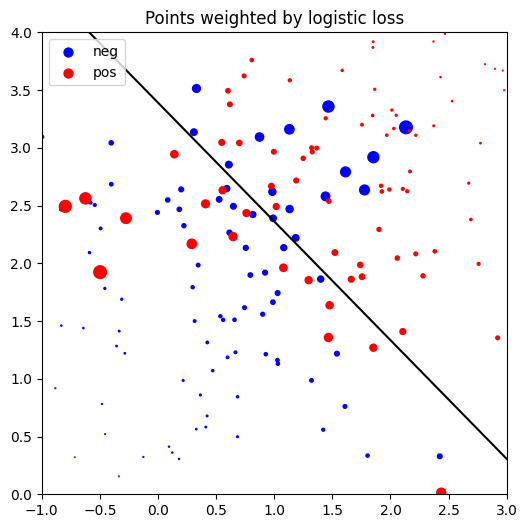

In [69]:
z_log = y_sim*lr_sim.decision_function(X_sim)
logisticloss = np.log(1 + np.exp(-z_log))
plt.scatter(X0[:,0],X0[:,1],s=logisticloss[N:]*30.,c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],s=logisticloss[:N]*30.,c='r',label='pos')
plt.plot(T,x2hat,c='k')
plt.xlim([-1,3])
plt.ylim([0,4])
plt.title("Points weighted by logistic loss")
_ = plt.legend(loc=2)
plt.show()

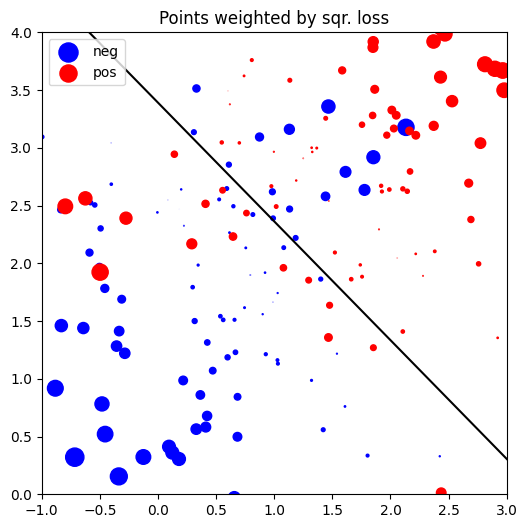

In [70]:
l2loss = (1-z_log)**2.
plt.scatter(X0[:,0],X0[:,1],s=l2loss[N:]*10.,c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],s=l2loss[:N]*10.,c='r',label='pos')
plt.plot(T,x2hat,c='k')
plt.xlim([-1,3])
plt.ylim([0,4])
plt.title("Points weighted by sqr. loss")
_ = plt.legend(loc=2)
plt.show()